In [2]:
from dsgd import DSClassifierMultiQ
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.datasets import load_iris,load_wine
from sklearn.preprocessing import StandardScaler

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
#aplicamos kmeans a los datos
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
#calculamos el silhouette score
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")
#calculamos el adjusted rand index
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari}")
#aplicamos DBSCAN a los datos
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
dbscan_labels = dbscan.labels_
#calculamos el silhouette score
dbscan_silhouette_avg = silhouette_score(X, dbscan_labels)
print(f"DBSCAN Silhouette Score: {dbscan_silhouette_avg}")
#calculamos el adjusted rand index
dbscan_ari = adjusted_rand_score(y, dbscan_labels)
print(f"DBSCAN Adjusted Rand Index: {dbscan_ari}")
#aplicamos Agglomerative Clustering a los datos
agglo = AgglomerativeClustering(n_clusters=3)
agglo.fit(X)
agglo_labels = agglo.labels_
#calculamos el silhouette score
agglo_silhouette_avg = silhouette_score(X, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette_avg}")
#calculamos el adjusted rand index
agglo_ari = adjusted_rand_score(y, agglo_labels)
print(f"Agglomerative Clustering Adjusted Rand Index: {agglo_ari}")

Silhouette Score: 0.5511916046195919
Adjusted Rand Index: 0.7163421126838476
DBSCAN Silhouette Score: 0.48603419703456857
DBSCAN Adjusted Rand Index: 0.5206185241703302
Agglomerative Clustering Silhouette Score: 0.5543236611296419
Agglomerative Clustering Adjusted Rand Index: 0.7311985567707746


In [4]:
print("Clustering results:")
#printeamos candidad de clusters
print(f"KMeans clusters: {len(set(labels))}")
print(f"DBSCAN clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Agglomerative Clustering clusters: {len(set(agglo_labels))}")

Clustering results:
KMeans clusters: 3
DBSCAN clusters: 2
Agglomerative Clustering clusters: 3


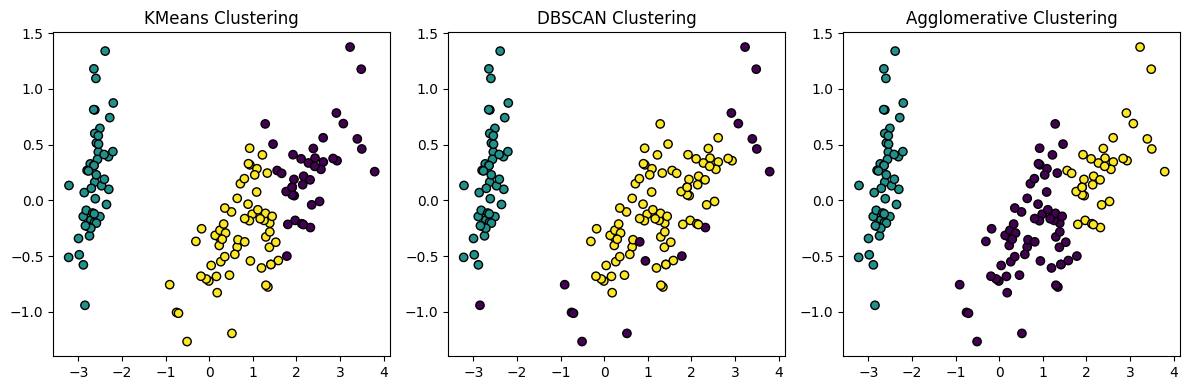

In [5]:
#visualizamos los resultados con pca
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)    
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('KMeans Clustering')
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering')
plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('Agglomerative Clustering')
plt.tight_layout()
plt.show()

In [7]:
DSC = DSClassifierMultiQ(3, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
losses, epoch, dt = DSC.fit(X, labels, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=iris.feature_names)

Optimization started

Training time: 6.06s, epochs: 200

Least training loss reached: 0.022


In [9]:
DSC.print_most_important_rules(threshold=0.32)



Most important rules for class 0

	[0.650] R11: petal length (cm) > 4.945
			0: 0.650	1: 0.000	2: 0.000	Unc: 0.350

	[0.638] R3: sepal length (cm) > 6.400
			0: 0.638	1: 0.000	2: 0.000	Unc: 0.362

	[0.626] R15: petal width (cm) > 1.712
			0: 0.540	1: 0.000	2: 0.188	Unc: 0.273

	[0.423] R6: 3.057 < sepal width (cm) < 3.350
			0: 0.318	1: 0.228	2: 0.016	Unc: 0.438

	[0.329] R7: sepal width (cm) > 3.350
			0: 0.176	1: 0.441	2: 0.000	Unc: 0.383

Most important rules for class 1

	[0.684] R8: petal length (cm) < 2.571
			0: 0.000	1: 0.684	2: 0.000	Unc: 0.316

	[0.600] R12: petal width (cm) < 0.687
			0: 0.000	1: 0.600	2: 0.000	Unc: 0.400

	[0.564] R1: 5.287 < sepal length (cm) < 5.843
			0: 0.000	1: 0.333	2: 0.622	Unc: 0.045

	[0.522] R7: sepal width (cm) > 3.350
			0: 0.176	1: 0.441	2: 0.000	Unc: 0.383

	[0.496] R0: sepal length (cm) < 5.287
			0: 0.000	1: 0.496	2: 0.000	Unc: 0.504

	[0.358] R6: 3.057 < sepal width (cm) < 3.350
			0: 0.318	1: 0.228	2: 0.016	Unc: 0.438

Most important rul

In [19]:
import pandas as pd
rules = DSC.find_most_important_rules(threshold=0.32)
rows = []
for cls, found in rules.items():
    for score, i, ps, sqrt_score, ms in found:
        row = {
            'class': cls,
            'rule_index': i,
            'rule': ps,
            'score': float(score),
            'sqrt_score': float(sqrt_score)
        }
        # separa las masas en columnas individuales
        if hasattr(ms, 'tolist'):
            masses_list = ms.tolist()
        else:
            masses_list = list(ms)
        for idx, mass in enumerate(masses_list):
            row[f'mass_{idx+1}'] = mass
        rows.append(row)
rules_df = pd.DataFrame(rows)
rules_df

,class,rule_index,rule,score,sqrt_score,mass_1,mass_2,mass_3,mass_4
0,0,11,petal length (cm) > 4.945,0.422276,0.649827,0.649827,0.000000,0.000000,0.350173
1,0,3,sepal length (cm) > 6.400,0.406457,0.637540,0.637540,0.000000,0.000000,0.362460
2,0,15,petal width (cm) > 1.712,0.392359,0.626385,0.539544,0.000000,0.187661,0.272796
3,0,6,3.057 < sepal width (cm) < 3.350,0.178631,0.422647,0.318119,0.227700,0.015703,0.438478
4,0,7,sepal width (cm) > 3.350,0.108445,0.329310,0.175719,0.441431,0.000000,0.382850
5,1,8,petal length (cm) < 2.571,0.467238,0.683548,0.000000,0.683548,0.000000,0.316452
6,1,12,petal width (cm) < 0.687,0.359632,0.599693,0.000000,0.599693,0.000000,0.400307
7,1,1,5.287 < sepal length (cm) < 5.843,0.317918,0.563842,0.000000,0.333046,0.621531,0.045424
8,1,7,sepal width (cm) > 3.350,0.272429,0.521947,0.175719,0.441431,0.000000,0.382850
9,1,0,sepal length (cm) < 5.287,0.245947,0.495931,0.000000,0.495931,0.000000,0.504069


In [16]:
#analizamos un dato random por clase en kmeans para ver que tan bien se agrupan
print(iris.feature_names)
for i in range(3):
    print(f"Cluster {i}:")
    cluster_data = X[labels == i]
    if len(cluster_data) > 0:
        random_data = cluster_data[np.random.choice(cluster_data.shape[0], 1, replace=False)][0]
        print(f"Random data from cluster {i}: ", end="")
        print(", ".join([f"{feature_name}: {value}" for feature_name, value in zip(iris.feature_names, random_data)]))
        pred, cls, df_rls, builder = DSC.predict_explain(random_data)
        print(pred, cls)
        print(df_rls)
    else:
        print(f"No data in cluster {i}")

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Cluster 0:
Random data from cluster 0: sepal length (cm): 6.9, sepal width (cm): 3.1, petal length (cm): 4.9, petal width (cm): 1.5
[0.34310898 0.10884245 0.54804856] 2
                                rule  mass_class_1  mass_class_2  \
0   1.199 < petal width (cm) < 1.712      0.002203        0.0000   
1  3.758 < petal length (cm) < 4.945      0.000000        0.0000   
2   3.057 < sepal width (cm) < 3.350      0.318119        0.2277   
3          sepal length (cm) > 6.400      0.637540        0.0000   

   mass_class_3  uncertainty  
0      0.633678     0.364119  
1      0.628964     0.371036  
2      0.015703     0.438478  
3      0.000000     0.362460  
Cluster 1:
Random data from cluster 1: sepal length (cm): 5.1, sepal width (cm): 3.3, petal length (cm): 1.7, petal width (cm): 0.5
[0.06497994 0.8960129  0.03900712] 1
                               rule  mass_class_1  mass_class_2  mass_class_3  \
0 

In [22]:
#como puedo ver si los clusters repreentan el mismo grupo entre kmeans y agglomerative clustering?
def compare_clusters(labels1, labels2):
    # Create a contingency table
    contingency_table = pd.crosstab(labels1, labels2)
    print("Contingency Table:")
    print(contingency_table)

    # Calculate the Pearson correlation coefficient
    corr, _ = pearsonr(labels1, labels2)
    print(f"Pearson correlation coefficient: {corr}")
    
compare_clusters(labels, agglo_labels)

#como podria usar eso para normalizar los clusters, es decir que los clusters de kmeans y agglomerative clustering representen el mismo grupo?def normalize_clusters(labels1, labels2):
    # Create a mapping from labels1 to labels2
def normalize_clusters(labels1, labels2):
    # Create a mapping from labels1 to labels2
    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)
    
    mapping = {}
    for label1 in unique_labels1:
        # Find the most common label2 for each label1
        mask = (labels1 == label1)
        most_common_label2 = pd.Series(labels2[mask]).mode()[0]
        mapping[label1] = most_common_label2
    
    # Apply the mapping to labels1
    normalized_labels1 = np.array([mapping[label] for label in labels1])
    
    return normalized_labels1   
normalized_labels = normalize_clusters(labels, agglo_labels)
compare_clusters(normalized_labels, agglo_labels)

Contingency Table:
col_0   0   1   2
row_0            
0       3   0  36
1       0  50   0
2      61   0   0
Pearson correlation coefficient: -0.9386562077654002
Contingency Table:
col_0   0   1   2
row_0            
0      61   0   0
1       0  50   0
2       3   0  36
Pearson correlation coefficient: 0.9386562077654004


In [24]:
#quiero usar normalized_labels + anglolabels para predecir, duplicamos X
X_combined = np.concatenate((X, X), axis=0)
normalized_labels_combined = np.concatenate((normalized_labels, agglo_labels), axis=0)
DSC = DSClassifierMultiQ(3, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
losses, epoch, dt = DSC.fit(X_combined, normalized_labels_combined, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=iris.feature_names)
DSC.print_most_important_rules(threshold=0.32)
#calculamos el silhouette score ccon las predicciones de DSC
predictions = DSC.predict(X)
silhouette_avg_dsc = silhouette_score(X, predictions)
print(f"DSC Silhouette Score: {silhouette_avg_dsc}")
#calculamos el adjusted rand index con las predicciones de DSC
dsc_ari = adjusted_rand_score(y, predictions)
print(f"DSC Adjusted Rand Index: {dsc_ari}")

Optimization started

Training time: 11.95s, epochs: 200

Least training loss reached: 0.020


Most important rules for class 0

	[0.748] R1: 5.287 < sepal length (cm) < 5.843
			0: 0.596	1: 0.341	2: 0.000	Unc: 0.063

	[0.675] R9: 2.571 < petal length (cm) < 3.758
			0: 0.675	1: 0.000	2: 0.000	Unc: 0.325

	[0.665] R4: sepal width (cm) < 2.764
			0: 0.665	1: 0.000	2: 0.000	Unc: 0.335

	[0.624] R2: 5.843 < sepal length (cm) < 6.400
			0: 0.624	1: 0.000	2: 0.000	Unc: 0.376

	[0.611] R10: 3.758 < petal length (cm) < 4.945
			0: 0.611	1: 0.000	2: 0.000	Unc: 0.389

	[0.553] R14: 1.199 < petal width (cm) < 1.712
			0: 0.553	1: 0.000	2: 0.000	Unc: 0.447

	[0.521] R13: 0.687 < petal width (cm) < 1.199
			0: 0.521	1: 0.000	2: 0.000	Unc: 0.479

	[0.479] R5: 2.764 < sepal width (cm) < 3.057
			0: 0.479	1: 0.000	2: 0.000	Unc: 0.521

Most important rules for class 1

	[0.621] R0: sepal length (cm) < 5.287
			0: 0.000	1: 0.621	2: 0.000	Unc: 0.379

	[0.611] R7: sepal width (cm) > 3.350
			0: 0.000	1: 

In [25]:
import pandas as pd
rules = DSC.find_most_important_rules(threshold=0.32)
rows = []
for cls, found in rules.items():
    for score, i, ps, sqrt_score, ms in found:
        row = {
            'class': cls,
            'rule_index': i,
            'rule': ps,
            'score': float(score),
            'sqrt_score': float(sqrt_score)
        }
        # separa las masas en columnas individuales
        if hasattr(ms, 'tolist'):
            masses_list = ms.tolist()
        else:
            masses_list = list(ms)
        for idx, mass in enumerate(masses_list):
            row[f'mass_{idx+1}'] = mass
        rows.append(row)
rules_df = pd.DataFrame(rows)
rules_df

,class,rule_index,rule,score,sqrt_score,mass_1,mass_2,mass_3,mass_4
0,0,1,5.287 < sepal length (cm) < 5.843,0.558774,0.747512,0.596143,0.341173,0.000000,0.062684
1,0,9,2.571 < petal length (cm) < 3.758,0.456228,0.675447,0.675447,0.000000,0.000000,0.324553
2,0,4,sepal width (cm) < 2.764,0.442816,0.665444,0.665444,0.000000,0.000000,0.334556
3,0,2,5.843 < sepal length (cm) < 6.400,0.389711,0.624268,0.624268,0.000000,0.000000,0.375732
4,0,10,3.758 < petal length (cm) < 4.945,0.373630,0.611253,0.611253,0.000000,0.000000,0.388747
5,0,14,1.199 < petal width (cm) < 1.712,0.305657,0.552862,0.552862,0.000000,0.000000,0.447138
6,0,13,0.687 < petal width (cm) < 1.199,0.271873,0.521415,0.521415,0.000000,0.000000,0.478585
7,0,5,2.764 < sepal width (cm) < 3.057,0.229833,0.479409,0.479409,0.000000,0.000000,0.520591
8,1,0,sepal length (cm) < 5.287,0.385853,0.621171,0.000000,0.621171,0.000000,0.378829
9,1,7,sepal width (cm) > 3.350,0.373389,0.611055,0.000000,0.528635,0.177691,0.293674
